In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, risk_models, expected_returns
from datetime import datetime, timedelta
import vectorbt as vbt

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'JNJ','FCEL', 'GME', 'AMC', 'TSLA',]

data = yf.download(tickers, start='2015-01-01', end='2023-01-01')['Adj Close']

data.head()

[*********************100%***********************]  8 of 8 completed


Ticker,AAPL,AMC,FCEL,GME,GOOGL,JNJ,MSFT,TSLA
Date,,,,,,,,
2015-01-02 00:00:00+00:00,24.373960,189.002716,227.520004,6.288959,26.412100,79.947594,40.232849,14.620667
2015-01-05 00:00:00+00:00,23.687300,184.135651,220.320007,6.460138,25.908844,79.389244,39.862881,14.006000
2015-01-06 00:00:00+00:00,23.689535,185.610550,208.800003,6.268492,25.269430,78.999146,39.277798,14.085333
2015-01-07 00:00:00+00:00,24.021708,188.633987,207.360001,6.195927,25.195112,80.743095,39.776833,14.063333
2015-01-08 00:00:00+00:00,24.944683,190.477570,211.679993,6.268492,25.282898,81.377968,40.946995,14.041333


In [ ]:
from google.colab import files
files.download('Data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(data.info())
print(data.describe())
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2014 entries, 2015-01-02 00:00:00+00:00 to 2022-12-30 00:00:00+00:00
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2014 non-null   float64
 1   AMC     2014 non-null   float64
 2   FCEL    2014 non-null   float64
 3   GME     2014 non-null   float64
 4   GOOGL   2014 non-null   float64
 5   JNJ     2014 non-null   float64
 6   MSFT    2014 non-null   float64
 7   TSLA    2014 non-null   float64
dtypes: float64(8)
memory usage: 141.6 KB
None
Ticker         AAPL          AMC         FCEL          GME        GOOGL  \
count   2014.000000  2014.000000  2014.000000  2014.000000  2014.000000   
mean      70.728458   164.949512    32.902468    12.091251    67.921318   
std       49.043277    96.792758    48.742122    15.324836    33.518758   
min       20.720037    19.799999     0.160000     0.700000    24.791613   
25%       29.132629   101.412704     3.630000     3.06

In [ ]:
returns = data.pct_change().dropna()

In [ ]:
#expected returns and the covariance matrix
mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data)

# Optimize for the maximum Sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print("Optimized Weights:", cleaned_weights)

ef.portfolio_performance(verbose=True)


Optimized Weights: OrderedDict([('AAPL', 0.21813), ('AMC', 0.0), ('FCEL', 0.0), ('GME', 0.0), ('GOOGL', 0.0), ('JNJ', 0.08184), ('MSFT', 0.61121), ('TSLA', 0.08882)])
Expected annual return: 23.7%
Annual volatility: 25.7%
Sharpe Ratio: 0.85


(0.23731875417087697, 0.25711107858931026, 0.8452329450883191)

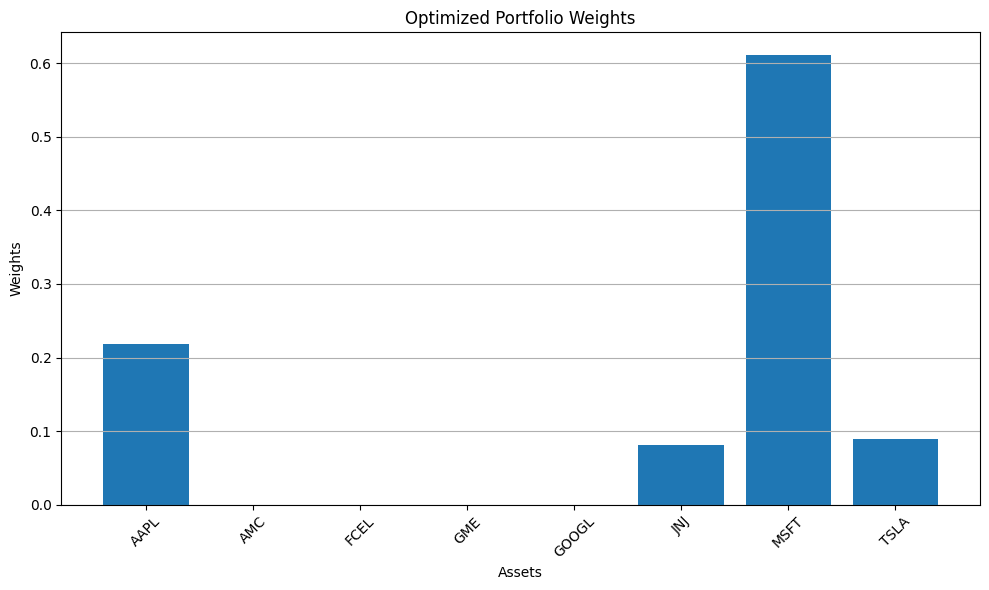

In [ ]:
assets = cleaned_weights.keys()
weights = cleaned_weights.values()

# Plotting the weights
plt.figure(figsize=(10, 6))
plt.bar(assets, weights)
plt.title('Optimized Portfolio Weights')
plt.xlabel('Assets')
plt.ylabel('Weights')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import plotly.graph_objects as go

# Function to simulate random portfolios
def random_portfolios(mu, S, num_portfolios=10000):
    results = np.zeros((3, num_portfolios))  # [0]: return, [1]: volatility, [2]: Sharpe ratio
    weights_record = np.zeros((num_portfolios, len(mu)))

    for i in range(num_portfolios):
        weights = np.random.random(len(mu))
        weights /= np.sum(weights)  # Normalize weights
        weights_record[i, :] = weights

        # Portfolio return
        portfolio_return = np.dot(weights, mu)
        results[0, i] = portfolio_return

        # Portfolio volatility
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(S, weights)))
        results[1, i] = portfolio_volatility

        # Portfolio Sharpe ratio (assuming risk-free rate is 0)
        results[2, i] = portfolio_return / portfolio_volatility

    return results, weights_record

# Generate random portfolios
num_portfolios = 10000
results, weights = random_portfolios(mu, S, num_portfolios)

# Extracting data for plotting
returns = results[0, :]
volatilities = results[1, :]
sharpe_ratios = results[2, :]

#optimal portfolio (maximum Sharpe ratio)
max_sharpe_idx = np.argmax(sharpe_ratios)
sdp_max_sharpe = volatilities[max_sharpe_idx]
rp_max_sharpe = returns[max_sharpe_idx]

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=volatilities,
    y=returns,
    mode='markers',
    marker=dict(color=sharpe_ratios, colorscale='Viridis', size=5, colorbar=dict(title='Sharpe Ratio')),
    name='Random Portfolios'
))

fig.add_trace(go.Scatter(
    x=[sdp_max_sharpe],
    y=[rp_max_sharpe],
    mode='markers+text',
    marker=dict(color='red', size=12),
    text=['Optimal Portfolio'],
    textposition='top center',
    name='Optimal Portfolio'
))

fig.update_layout(
    title='Efficient Frontier',
    xaxis_title='Volatility (Standard Deviation)',
    yaxis_title='Expected Return',
    template='plotly_white',
    showlegend=True
)

fig.show()


In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# random portfolios
num_portfolios = 10000
results, weights = random_portfolios(mu, S, num_portfolios)

portfolio_data = pd.DataFrame({
    'Return': results[0, :],
    'Volatility': results[1, :],
    'Sharpe Ratio': results[2, :],
})

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=np.sort(portfolio_data['Volatility']),
    y=portfolio_data.loc[np.argsort(portfolio_data['Volatility']), 'Return'],
    mode='lines',
    name='Efficient Frontier',
    line=dict(color='blue', width=2)
))

# optimal portfolio (maximum Sharpe ratio)
max_sharpe_idx = np.argmax(results[2, :])
optimal_weights = weights[max_sharpe_idx]
sdp_max_sharpe = results[1, max_sharpe_idx]
rp_max_sharpe = results[0, max_sharpe_idx]

# optimal portfolio point
fig.add_trace(go.Scatter(
    x=[sdp_max_sharpe],
    y=[rp_max_sharpe],
    mode='markers+text',
    marker=dict(color='red', size=12),
    text=['Optimal Portfolio'],
    textposition='top center',
    name='Optimal Portfolio'
))

fig.update_layout(
    title='Efficient Frontier with Monte Carlo Simulation',
    xaxis_title='Volatility (Standard Deviation)',
    yaxis_title='Expected Return',
    template='plotly_white',
    showlegend=True
)

fig.show()

print("Optimal Weights:", optimal_weights)


Optimal Weights: [0.23859663 0.00212548 0.0261498  0.01333993 0.00780061 0.32013305
 0.33537675 0.05647776]


In [ ]:
portfolio_data = pd.DataFrame({
    'Return': results[0,:], # Use the first row of the results array
    'Volatility': volatilities,
    'Sharpe Ratio': sharpe_ratios
})

portfolio_data.to_csv('portfolio_data.csv', index=False)

print(portfolio_data.head())

     Return  Volatility  Sharpe Ratio
0  0.121369    0.420260      0.096298
1  0.145888    0.443879      0.150836
2  0.052077    0.409787      0.131658
3  0.062943    0.354903      0.345255
4  0.105345    0.471095      0.330434


In [ ]:
data = yf.download(tickers, start='2015-01-01', end='2023-01-01')['Adj Close']
returns = data.pct_change().dropna()

[*********************100%***********************]  8 of 8 completed


In [ ]:
results_df = pd.DataFrame(results.T, columns=['Return', 'Volatility', 'Sharpe Ratio'])

max_sharpe_idx = results_df['Sharpe Ratio'].idxmax()
optimal_weights = weights[max_sharpe_idx]
optimal_return = results_df['Return'].iloc[max_sharpe_idx]
optimal_volatility = results_df['Volatility'].iloc[max_sharpe_idx]

print("Optimal Portfolio Weights:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {optimal_weights[i]:.2%}")

print(f"Expected Return: {optimal_return:.2%}")
print(f"Expected Volatility: {optimal_volatility:.2%}")

Optimal Portfolio Weights:
AAPL: 23.86%
MSFT: 0.21%
GOOGL: 2.61%
JNJ: 1.33%
FCEL: 0.78%
GME: 32.01%
AMC: 33.54%
TSLA: 5.65%
Expected Return: 17.86%
Expected Volatility: 21.88%


In [ ]:
# Parameters
init_cash = 100_000
short_window = 40
long_window = 100
fees = 0.001  # 0.1% trading fees
slippage = 0.001  # 0.1% slippage

# Calculate moving averages
short_mavg = data.rolling(window=short_window).mean()
long_mavg = data.rolling(window=long_window).mean()

# Create entry and exit signals
entries = (short_mavg > long_mavg).astype(int)  # Buy signal when short MA crosses above long MA
exits = (short_mavg < long_mavg).astype(int)    # Sell signal when short MA crosses below long MA

# Initialize portfolio with weights based on signals
portfolio = vbt.Portfolio.from_signals(
    data,
    entries,
    exits,
    init_cash=init_cash,
    fees=fees,
    slippage=slippage,
    size=1  # Allocate 100% of cash to each entry signal
)


In [ ]:
# Portfolio statistics
stats = portfolio.stats()
print(stats)

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2015-01-02 00:00:00+00:00
End                           2022-12-30 00:00:00+00:00
Period                                             2014
Start Value                                    100000.0
End Value                                  100042.95023
Total Return [%]                                0.04295
Benchmark Return [%]                         252.160852
Max Gross Exposure [%]                         0.259894
Total Fees Paid                                1.616361
Max Drawdown [%]                               0.131614
Max Drawdown Duration                            852.25
Total Trades                                     10.125
Total Closed Trades                                10.0
Total Open Trades                                 0.125
Open Trade PnL                                -0.062096
Win Rate [%]                                  41.114719
Best Trade [%]                                487.43495
Worst Trade [%]                              -26

<ipython-input-24-e1210a48dfdd>:2: UserWarning:

Object has multiple columns. Aggregating using <function mean at 0x7d2551e07c70>. Pass column to select a single column/group.



In [ ]:
portfolio.total_profit()

,total_profit
Ticker,
AAPL,63.548525
AMC,-17.456142
FCEL,-70.319691
GME,9.029691
GOOGL,53.954100
JNJ,7.683201
MSFT,196.747856
TSLA,100.414297


In [ ]:
portfolio.total_return()

,total_return
Ticker,
AAPL,0.000635
AMC,-0.000175
FCEL,-0.000703
GME,0.000090
GOOGL,0.000540
JNJ,0.000077
MSFT,0.001967
TSLA,0.001004


<Figure size 1000x600 with 0 Axes>

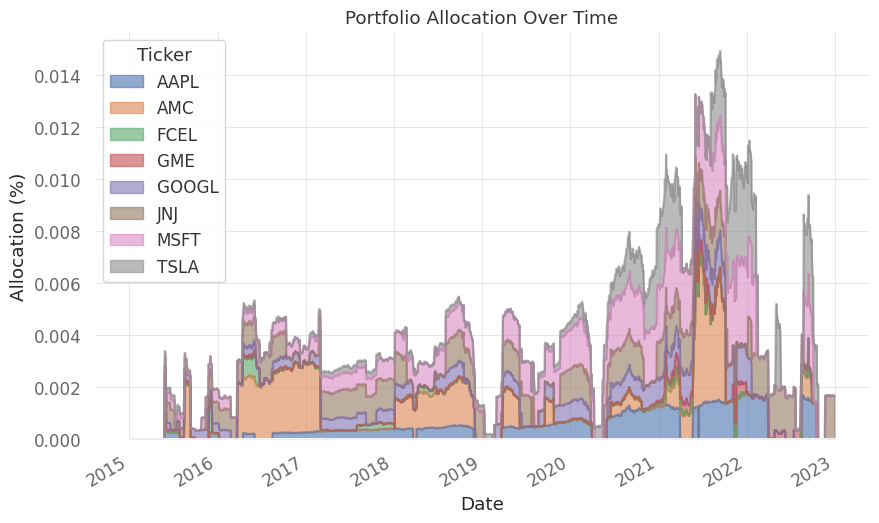

In [ ]:
# Get the allocation (weights) over time
allocation = portfolio.asset_value() / portfolio.value()  # Weights of each asset over time

plt.figure(figsize=(10, 6))
allocation.plot.area(alpha=0.6, stacked=True)
plt.title('Portfolio Allocation Over Time')
plt.ylabel('Allocation (%)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

In [ ]:
fig = portfolio.total_return().vbt.heatmap(
    x_level='fast_window', y_level='slow_window', slider_level='symbol', symmetric=True,
    trace_kwargs=dict(colorbar=dict(title='Total return', tickformat='%')))
fig.show()

In [ ]:
portfolio.plot(column='AAPL').show()

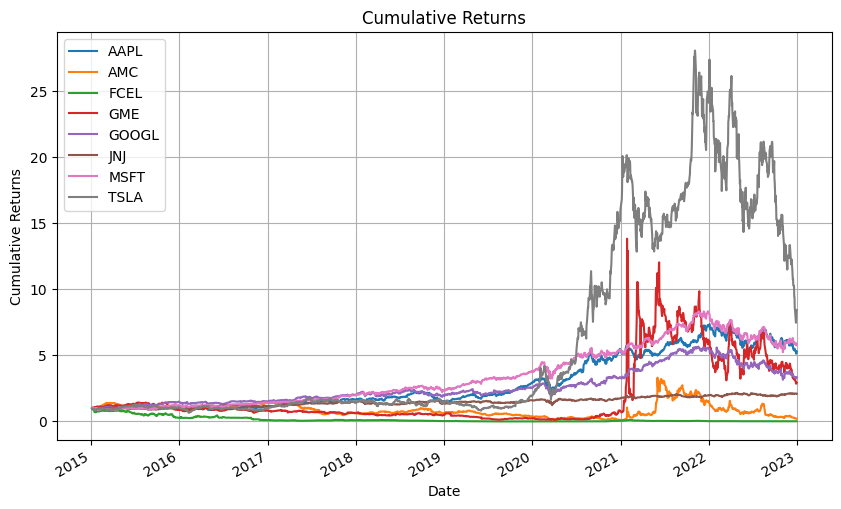

In [ ]:
# Cumulative returns plot
cumulative_returns = (1 + returns).cumprod()
cumulative_returns.plot(figsize=(10, 6), title='Cumulative Returns', label=tickers)
#portfolio.total_return.plot(label='Portfolio', linestyle='--', color='black')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Create a figure for the allocation over time


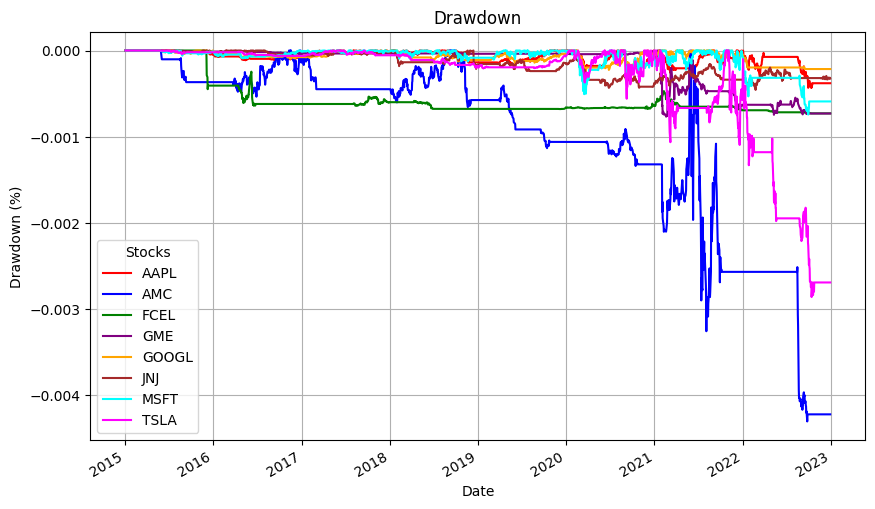

In [ ]:
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'cyan', 'magenta']

drawdown.plot(figsize=(10, 6), title='Drawdown', color=colors)
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.grid()
plt.legend(title="Stocks")
plt.show()


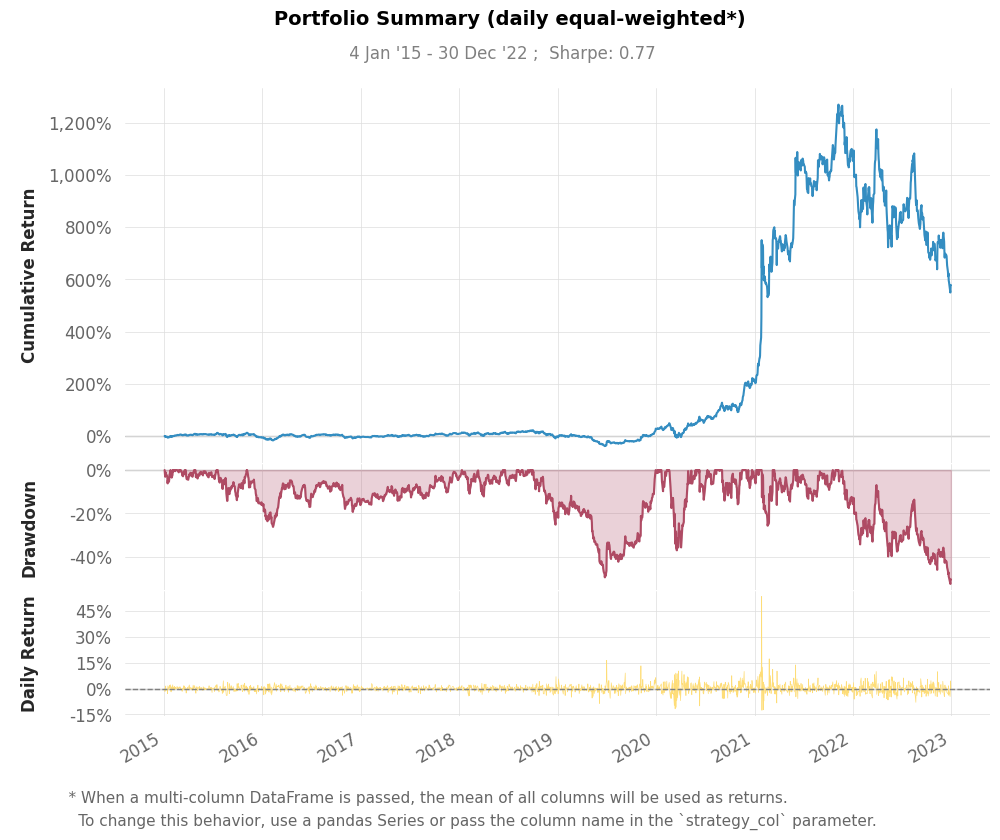

In [ ]:
import matplotlib.pyplot as plt
returns = data.vbt.to_returns()
returns.vbt.returns.qs.plot_snapshot()

In [ ]:
returns_pd = returns
returns_pd[~returns_pd.isnull()]

Ticker,AAPL,AMC,FCEL,GME,GOOGL,JNJ,MSFT,TSLA
Date,,,,,,,,
2015-01-02 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05 00:00:00+00:00,-0.028172,-0.025751,-0.031646,0.027219,-0.019054,-0.006984,-0.009196,-0.042041
2015-01-06 00:00:00+00:00,0.000094,0.008010,-0.052288,-0.029666,-0.024679,-0.004914,-0.014677,0.005664
2015-01-07 00:00:00+00:00,0.014022,0.016289,-0.006897,-0.011576,-0.002941,0.022076,0.012705,-0.001562
2015-01-08 00:00:00+00:00,0.038423,0.009773,0.020833,0.011712,0.003484,0.007863,0.029418,-0.001564
...,...,...,...,...,...,...,...,...
2022-12-23 00:00:00+00:00,-0.002798,-0.103870,0.026923,0.013630,0.016750,0.002542,0.002267,-0.017551
2022-12-27 00:00:00+00:00,-0.013878,-0.084091,-0.037453,-0.093625,-0.020621,-0.000282,-0.007414,-0.114089
2022-12-28 00:00:00+00:00,-0.030685,-0.047146,-0.007782,-0.015385,-0.015677,-0.004340,-0.010255,0.033089


In [ ]:
sr1 = pd.Series(portfolio_data['Return'])
sr2 = pd.Series(portfolio_data['Volatility'])
sr1.vbt.plot_against(sr2).show()

In [ ]:
#Save
portfolio.save('first_portfolio.pkl')

In [ ]:
from flask import Flask
from pyngrok import ngrok
import os

# Initialize the Flask app
app = Flask(__name__)

@app.route('/')
def hello():
    return "Hello"

# Set up ngrok tunnel
ngrok.set_auth_token("2h5aAn50AptbQqQwFvR4FUAA4kF_6B31Jv4C4Cn67nBjtX46Z")  # Removed extra text after authtoken
public_url = ngrok.connect(5000)
print(f"Public URL: {public_url}")

# Run the Flask app
app.run(port=5000)

Public URL: NgrokTunnel: "https://ae37-34-125-248-186.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [25/Sep/2024 19:16:00] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [25/Sep/2024 19:16:01] "GET /favicon.ico HTTP/1.1" 404 -
